<a href="https://colab.research.google.com/github/daveselinger/covid_rapid_test_simulation2/blob/main/simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import numpy as np
from enum import Enum
import random
from dataclasses import dataclass
import math
from scipy.stats import norm
import matplotlib.pyplot as plt
from google.colab import widgets


In [2]:
@dataclass
class SimulationParameters :

    # Starting Population size (Int) 
    populationSize = 10000

    # Starting infected rate (Float, 0-1) 
    startingInfectionRate = 0.004

    # Testing interval: Start out with every 3 days (Float: 0-100.0) 
    testingInterval = 3.0

    # Testing rate 
    testingRate = 0.6

    # Testing rate 
    testingRateRandom = 0.0

    # False positive % (Float, 0-1) 
    falsePositiveRate = 0.01

    # False negative % (Float, 01) 
    falseNegative = 0.02

    # % of symptomatic that will self isolate if symptomatic. 
    selfIsolationRate = 0.0

    # % of positives that will quarantine effectively (after positive test). 
    positiveQuarantineRate = 0.9

    # isolation after positive test or self isolation 
    positiveTestIsolationInterval = 21

    # Days to contagious (int) 
    daysToContagious = 2.5
    daysToContagiousSTD = 0.5

    # Days to detectable (Float) 
    daysToDetectable = 2.5
    daysToDetectableSTD = 0.5

    # Days to symptos (Float) 
    daysToSymptoms = 5.5
    daysToSymptomsSTD = 2

    # Days to Recovery 
    daysToRecovery = 10
    daysToRecoverySTD = 4

    # Mortality rate (Float, 0-1) 
    mortalityRate = 0.01

    # The rate of people who are infected but do not show symptoms. 
    asymptomaticRate = 0.2

    # Recovered Resistance (%, as a probability?) 
    recoveredResistance = 0.98

    # Mean/STD of # of interactions per day 
    numInteractions = 2.5

    #  
    numInteractionsSTD = 1.0

    # Mean/STD of transmission per interaction 
    transmissionRate = 0.05

    #  
    transmissionRateSTD = 0.1

    # Testing rate PCR 
    testingRatePcr = 0.000

    # RandomTesting rate PCR 
    testingRateRandomPcr = 0.003

    # Testing interval for PCR: Start out with every 3 days (Float: 0-100.0) 
    testingIntervalPcr = 3.0

    # False positive % for PCR (Float, 0-1) 
    falsePositiveRatePcr = 0.01

    # False negative % for PCR (Float, 01) 
    falseNegativePcr = 0.02

    # constructor(props =:) {
    #     Object.assign(this, props)
    # 

    # days_to_pcr detectable. Sampled for this actor. 
    daysToPcrDetectable = 2
    daysToPcrDetectableSTD = 0.5

    # The duration of virus shedding when antigen detection is positive. Sampled for this actor. 
    durationDaysOfPcrDetection = 24
    durationDaysOfPcrDetectionSTD = 7

    # The delay from PCR test to results. Isolation is delayed by this ammount 
    daysToPcrResults = 1.5

    # days until the rapid test will detect. Sampled for this actor.  
    daysToAntigenDetectable = 3
    daysToAntigenDetectableSTD = 1

    # The duration of virus shedding when antigen detection is positive. Sampled for this actor. 
    durationDaysOfAntigenDetection = 10
    durationDaysOfAntigenDetectionSTD = 3

    # Daily Vacination rate 
    vaccinationRate = 0.0035

    # Vaccination delay 
    vaccinationDelay = 28

    # Vaccination effectiveness 
    vaccinationEfficacy = 0.95

    # Non compliance rate
    nonCompliantRate = 0.0




In [3]:


class ACTOR_STATUS (Enum):
    SUSCEPTIBLE= 0
    EXPOSED=     1
    INFECTIOUS=  2
    RECOVERED=   3
    DECEASED=    4


# Activity is a risk modifier. 1.0 is normal, 0.0 is safe, >1.0 is risky
@dataclass
class ACTIVITY:
    NORMAL= 1.0
    SAFE=   0.1


# Protection is 1.0 for no protection, 0 for full protection
@dataclass
class ACTOR_PROTECTION:
    NONE= 1.0
    MASK= 0.1



In [4]:
def gaussianRandom(mu,var=1.0):
  return norm.rvs(mu,var)


class Infection:
    # The actor who is infected 
    myActor = None

    # The day the infection started. Date of exposure. 
    # TODO: Start doing this off a timestamp instead of a tick
    
    startDay = None

    # Number of days infected 
    infectedTime = 0

    # The days until contagious. Sampled for this actor. 
    daysToContagious = -1

    # Whether this infection will be asymptomatic. Sampled for this actor. 
    asymptomatic = False

    # If symptomatic, the days until symptomatic. Sampled for this actor. 
    daysToSymptomatic = -1

    # days_to_pcr detectable. Sampled for this actor. 
    daysToPcrDetectable = -1

    # days until the rapid test will detect. Sampled for this actor.  
    daysToAntigenDetectable = -1

    # The last day of contagious. Sampled for this actor. 
    daysToNotContagious = -1

    # The last day of symptoms. Sampled for this actor. 
    daysToNotSymptomatic = -1
        
    # The last day of detectable virus shedding using PCR test. Sampled for this actor. 
    daysToPcrNotDetectable = -1

    # The last day of detectable virus shedding using antigen test. Sampled for this actor. 
    daysToAntigenNotDetectable = -1

    def __init__(self,actor):
        self.myActor = actor
        self.infectedTime = 0
        self.asymptomatic = ( random.random() < self.myActor.simulationParameters.asymptomaticRate)

        #TODO: Sample these values in the future!
        params=self.myActor.simulationParameters
        self.daysToContagious = gaussianRandom(params.daysToContagious, params.daysToContagiousSTD)
        self.daysToNotContagious = self.daysToContagious + gaussianRandom(params.daysToRecovery-params.daysToContagious,params.daysToRecoverySTD)
        self.daysToSymptomatic = gaussianRandom(params.daysToSymptoms,params.daysToSymptomsSTD)
        self.daysToNotSymptomatic = self.daysToSymptomatic + gaussianRandom(params.daysToRecovery,params.daysToRecoverySTD)
        self.daysToPcrDetectable = gaussianRandom(params.daysToPcrDetectable,params.daysToPcrDetectableSTD)
        self.daysToPcrNotDetectable = self.daysToPcrDetectable + gaussianRandom(params.durationDaysOfPcrDetection,params.durationDaysOfPcrDetectionSTD)
        # this assures that the sampled daysToAntigenDetectible is after the sampled daysToPcrDetectible 
        self.daysToAntigenDetectable = self.daysToPcrDetectable + gaussianRandom(params.daysToAntigenDetectable-params.daysToPcrDetectable,params.daysToAntigenDetectableSTD)
        self.daysToAntigenNotDetectable =self.daysToAntigenDetectable +  gaussianRandom(params.durationDaysOfAntigenDetection,params.durationDaysOfAntigenDetectionSTD)
        
    

    def tick(self,days=1.0):
        self.infectedTime += days
    

    def duration(self):
        return self.infectedTime
    

    def detectPcrTest(self):
        return (self.duration() >  self.daysToPcrDetectable and 
            self.duration() < self.daysToPcrNotDetectable )
    

    def detectRapidTest(self):
        return (self.duration() > self.daysToAntigenDetectable and 
         self.duration() < self.daysToAntigenNotDetectable)
    

    def isSymptomatic(self):
        if (self.asymptomatic):
            return False
        
        return (self.duration() > self.daysToSymptomatic and
         self.duration() < self.daysToNotSymptomatic)
    

    def isContagious(self):
        return (self.duration() > self.daysToContagious and
         self.duration() < self.daysToNotContagious)
    


In [5]:


class Actor:
    simulation = None
    
    # The parameters of the overall simulation for this actor 
    simulationParameters = None

    # Blue-healthy/Susceptible. 
    status = ACTOR_STATUS.SUSCEPTIBLE

    # Isolated/Not isolated (impacted by rapid testing). 
    isolated = False

    # Number of days of isolation remaining. 
    isolatedRemain = 0

    # Number of days to delay before beginning isolation 
    isolateAfterRemain = 0

    # The number of days this actor was infected. 
    infectedTime = None


    # The horizontal position of this actor. 
    xPosition = 0

    # The vertical position of this actor. 
    yPosition = 0

    # ID of this actor. 
    id = 0

    # By default actor has no protection 
    protection = ACTOR_PROTECTION.NONE

    # Days since most recent rapid test 
    testTime = None

    # Days since most recent PCR test 
    testTimePcr = None

    # Days isolated  
    daysIsolated = 0

    # Whether or not this actor is showing symptoms once infected. 
    isAsymptomatic = False

    # Whether or not this actor is showing symptoms or not. 
    isSymptomatic = False

    # Number of days remaining from vaccination to protection. 
    vaccinationRemain = 0

    # actor has been  vaccinated. 
    isVaccinated = False 

    # actor has vaccine protection. 
    isVaccinatedProtected=False  

    # Whether or not this actor will self-isolate when symptoms appear. 
    willSelfIsolate = True

    # Nmber of tests conducted. 
    testsConducted = 0

    # Nmber of Pcr tests conducted. 
    testsConductedPcr = 0

    # Whether or not this actor will comply with orders. 
    isNonCompliant = False

    # Is actor part of the rapid test testing program 
    isTesting = False

    # Is actor part of the Pcr routine testing program 
    isTestingPcr = False

    myInfection = None

    def __init__(self,simulation):
        self.simulation = simulation

        # Initialize the day of the next test using uniform random.
        #  self.testTimePcr = math.floor(random.random() * self.simulationParameters.testingIntervalPcr)
        #  self.testTime = math.floor(random.random() * self.simulationParameters.testingInterval)

    
        # The parameters of the overall simulation for this actor 
        self.simulationParameters = simulation.simulationParameters

        # Blue-healthy/Susceptible. 
        self.status = ACTOR_STATUS.SUSCEPTIBLE

        # Isolated/Not isolated (impacted by rapid testing). 
        self.isolated = False

        # Number of days of isolation remaining. 
        self.isolatedRemain = 0

        # Number of days to delay before beginning isolation 
        self.isolateAfterRemain = 0

        # The number of days this actor was infected. 
        self.infectedTime = None


        # The horizontal position of this actor. 
        self.xPosition = 0

        # The vertical position of this actor. 
        self.yPosition = 0

        # ID of this actor. 
        self.id = 0

        # By default actor has no protection 
        self.protection = ACTOR_PROTECTION.NONE

        # Days since most recent rapid test 
        self.testTime = None

        # Days since most recent PCR test 
        self.testTimePcr = None

        # Days isolated  
        self.daysIsolated = 0

        # Whether or not this actor is showing symptoms once infected. 
        self.isAsymptomatic = False

        # Whether or not this actor is showing symptoms or not. 
        self.isSymptomatic = False

        # Number of days remaining from vaccination to protection. 
        self.vaccinationRemain = 0

        # actor has been  vaccinated. 
        self.isVaccinated = False 

        # actor has vaccine protection. 
        self.isVaccinatedProtected=False  

        # Whether or not this actor will self-isolate when symptoms appear. 
        self.willSelfIsolate = True

        # Nmber of tests conducted. 
        self.testsConducted = 0

        # Nmber of Pcr tests conducted. 
        self.testsConductedPcr = 0

        # Whether or not this actor will comply with orders. 
        self.isNonCompliant = False

        # Is actor part of the rapid test testing program 
        self.isTesting = False

        # Is actor part of the Pcr routine testing program 
        self.isTestingPcr = False

        self.myInfection = None

    # Infect the individual. Starts as EXPOSED.
     
    def infect(self):
        self.infectedTime = 0
        self.status = ACTOR_STATUS.EXPOSED
        self.isAsymptomatic = random.random() < self.simulationParameters.asymptomaticRate
        self.willSelfIsolate = random.random() < self.simulationParameters.selfIsolationRate
        self.myInfection = Infection(self)
    

    def vaccinate(self):
        self.isVaccinated=True
        self.vaccinationRemain = gaussianRandom(self.simulationParameters.vaccinationDelay)
  
    
    # Perform rapid test on actor
     
    def rapidTest(self):
        self.testsConducted+=1
        self.testTime = 0

        if (self.status == ACTOR_STATUS.EXPOSED
             or  self.status == ACTOR_STATUS.INFECTIOUS):
            if (self.myInfection.detectRapidTest()
                and random.random() > self.simulationParameters.falseNegative):
                #print(('Tested positive', self.id)
                return True
            
        
        if(random.random() < self.simulationParameters.falsePositiveRate):
            #print(('False positive ', self.id)
            return True
        
        return False
    
    # Perform PCR test on actor
     
    def pcrTest(self):
        self.testsConductedPcr+=1
        self.testTimePcr = 0

        if (self.status == ACTOR_STATUS.EXPOSED  or  self.status == ACTOR_STATUS.INFECTIOUS):
            if (self.myInfection.detectPcrTest()
                and random.random() > self.simulationParameters.falseNegativePcr):
              #print('Tested PCR positive', self.id)
              return True
            
        
        if(random.random() < self.simulationParameters.falsePositiveRatePcr):
            #print(('False positive ', self.id)
            return True
        
        return False
    

    #  Isolate actor for a number of days.
    #  @param:number days - The number of days to isolate (int).
     
    def isolateFor(self,days,after=0):
        if(after == 0):
            self.isolated = True
        else:
            self.isolateAfterRemain = after
        
        self.isolatedRemain = days

    
    
    #
    # Perform updates to actor for each cycle.
     
    def tick(self,days=1.0):
        # First progress the status based on lifecycle
        if(self.myInfection is not None and self.status != ACTOR_STATUS.RECOVERED):
            if (self.status == ACTOR_STATUS.EXPOSED):
                if (self.myInfection.isContagious()):
                    self.status = ACTOR_STATUS.INFECTIOUS
                
            elif (self.status == ACTOR_STATUS.INFECTIOUS):
                if (not self.myInfection.isContagious()):
                    if (random.random() < self.simulationParameters.mortalityRate):
                        self.status = ACTOR_STATUS.DECEASED
                    else:
                        self.status = ACTOR_STATUS.RECOVERED
                    
                 
            
            self.isSymptomatic = self.myInfection.isSymptomatic()
        


        if (self.isolateAfterRemain > 0):
            self.isolateAfterRemain-= days
            if(self.isolateAfterRemain<=0):
                self.isolated=True
            
        

        # Advance the clock
        if self.infectedTime is not None:
          self.infectedTime += days

        if (self.myInfection is not None):
            self.myInfection.tick(days)
        

        if (self.isolated):
            self.daysIsolated += days
            self.isolatedRemain -= days
            if (self.isolatedRemain <= 0):
                self.isolated=False
            
         
        if (self.testTime is not None):
            self.testTime += days
        
        if (self.testTimePcr is not None):
            self.testTimePcr += days
        
        if (self.vaccinationRemain>0 ):
            self.vaccinationRemain-=days

            # This can only happen once.
            if(self.vaccinationRemain<=0):
                if(random.random()<self.simulationParameters.vaccinationEfficacy):
                    self.isVaccinatedProtected=True
        random.random()<self.simulationParameters.vaccinationEfficacy
  

In [6]:
  

@dataclass
class RunStatistics:
    susceptible=0
    infected=0
    recovered=0
    deceased=0
    testsConducted=0
    daysLost=0

class Simulation:
    def __init__(self,simulationParameters):
        self.simulationParameters = simulationParameters
        self.actors = []
        self.totals = RunStatistics()
        self.daysElapsed = 0

        rows = math.floor(math.sqrt(self.simulationParameters.populationSize))
        for i in range(self.simulationParameters.populationSize):
            a = Actor(self)
            a.xPosition = i % rows
            a.yPosition = math.floor(i/rows)
            a.id = i
            a.isTesting = random.random() < self.simulationParameters.testingRate
            a.isTestingPcr = random.random() < self.simulationParameters.testingRatePcr
            a.isNonCompliant = random.random()<self.simulationParameters.nonCompliantRate
            self.actors.append(a)
        
        # Initial exposed subpopulation
        for cnt in range( int(max(1, self.simulationParameters.startingInfectionRate * self.simulationParameters.populationSize))):
            idx = math.floor(random.random() * len(self.actors))
            self.actors[idx].infect()
            self.totals.infected+=1
        

        # The remaining susceptible, after we've created the initially infected
        self.totals.susceptible = self.simulationParameters.populationSize - self.totals.infected
    

    #*
    #Models transmission from an infected individual to a susceptible
    #individual.
    # duration is in days (default is 15 minutes 0.0104)
    # 
    # TODO: model full viral load dynamics and exposure duration
     
    def hasBeenExposed(self,susceptible, infected, duration=0.0104, activity = ACTIVITY.NORMAL):
        if (infected.status != ACTOR_STATUS.INFECTIOUS
             or  susceptible.status != ACTOR_STATUS.SUSCEPTIBLE
        ):
            return False
        
        if (susceptible.isVaccinatedProtected ):
            return False
        
        if (infected.isolated):
            return False
        
        if (random.random() < self.simulationParameters.transmissionRate
            * infected.protection
            * activity
            * duration / 0.0104
        ):
            susceptible.infect()
            return True
        
        return False
    

    # Handles the disease progression in all actors
     
    def tickDisease(self,days = 1):
        self.daysElapsed+=days

        newTotals = RunStatistics()
        

        # This handles disease progression
        # TODO: cost model
        for actor in self.actors:
            actor.tick(days)
            # Update totals
            if (actor.status == ACTOR_STATUS.RECOVERED): 
                  newTotals.recovered+=1  
            elif (actor.status == ACTOR_STATUS.SUSCEPTIBLE): 
                  newTotals.susceptible+=1  
            elif (actor.status == ACTOR_STATUS.INFECTIOUS): 
                  newTotals.infected+=1  
            elif (actor.status ==  ACTOR_STATUS.EXPOSED): 
                  newTotals.infected+=1  
            elif (actor.status ==  ACTOR_STATUS.DECEASED): 
                  newTotals.deceased+=1  
            
            newTotals.testsConducted+=actor.testsConducted
            newTotals.daysLost+=actor.daysIsolated
        
        self.totals = newTotals
    

    
      # Check for exposure in either direction and infect the susceptible actor
      # if exposure occured. This can be called for collision detect based interactions.
      # @returns:Boolean - Whether there was a resulting infection `TRUE` or not `FALSE`.
     
    def checkExposure(self,actor, other, duration = 0.0104, activity = ACTIVITY.NORMAL):
        if(self.hasBeenExposed(other, actor)):
            #print((actor.id, 'infects', other.id)
            other.infect()
            return True
        
        if(self.hasBeenExposed(actor, other)):
            #print((other.id, 'infects', actor.id)
            actor.infect()
            return True
        
        return False
    

    
    #  Generate daily interactions based on simulation parameters. 
    #  This is not used if interactions are based on collision detection.
     
    def tickInteractions(self,days = 1.0):
        for actor in self.actors:
            if (actor.status == ACTOR_STATUS.INFECTIOUS and not actor.isolated): 
                # Determine if we infect based on # of interactions and % of day passed
                if (random.random() < days):
                    interactions=gaussianRandom(self.simulationParameters.numInteractions,self.simulationParameters.numInteractionsSTD)
                    for encounter in range(int(interactions)) :
                        # Pick a random nearby actor to expose
                        other = self.actors[math.floor(random.random() * len(self.actors))]
                        self.checkExposure(other, actor)
                    
                
            
         
    


    #   This is the outer tick. To be overriden by subclasses.
    #   Should implement policies such as social distancing,
    #   isolation or testing.
    #   This base model just picks random actors to infect
     
    def tick(self,days = 1):
        self.tickInteractions(days)
        self.tickRapidTesting(days)
        self.tickPcrTesting(days)
        self.tickVaccination(days)
        self.tickDisease(days)
    

    # Implement daily rapid testing policy
     
    def tickRapidTesting(self,days = 1.0): 
        # Perform rapid testing
        for actor in self.actors:
            if(((actor.isTesting and (actor.testTime is None
                 or  actor.testTime >= self.simulationParameters.testingInterval))
                 or  (random.random()<self.simulationParameters.testingRateRandom/days))
                and not actor.isolated
                and actor.rapidTest()):
                # TODO: Can sample these as well.
                if(random.random()<self.simulationParameters.positiveQuarantineRate):
                    actor.isolateFor(self.simulationParameters.positiveTestIsolationInterval)
                    #print(('Isolated ', actor.id)                    
                else:
                    pass
                    #print(('Isolation non compliance', actor.id)
                

            # TODO: Some actors become sick and never become "unsick" so they isolate forever.
            if (actor.isSymptomatic and actor.willSelfIsolate and not actor.isolated):
                actor.isolateFor(self.simulationParameters.positiveTestIsolationInterval)
            
        
    
    # Implement pcr testing policy
     
    def tickPcrTesting(self,days = 1.0): 
        # Perform pcr testing
        for actor in self.actors:
            if( 
                ((random.random()<self.simulationParameters.testingRateRandomPcr/days)  or 
                    (actor.isTestingPcr and (actor.testTimePcr is None  or  
                        actor.testTimePcr >= self.simulationParameters.testingIntervalPcr)))
                        and not actor.isolated and actor.pcrTest()):
                # TODO: Can sample these as well.
                if(random.random()<self.simulationParameters.positiveQuarantineRate):
                    #print('Isolated PCR', actor.id) 
                    actor.isolateFor(self.simulationParameters.positiveTestIsolationInterval,
                        self.simulationParameters.daysToPcrResults)
                else:
                    pass
                    #print(('Isolation non compliance', actor.id)
                
            
            # TODO: Some actors become sick and never become "unsick" so they isolate forever.
            if (actor.isSymptomatic and actor.willSelfIsolate and not actor.isolated):
                actor.isolateFor(self.simulationParameters.positiveTestIsolationInterval)
            
    def tickVaccination(self,days = 1.0): 
        # Perform random vaccination
        # TODO: find a better way to do
        for actor in self.actors:
            if(not actor.isVaccinated and 
                random.random()<self.simulationParameters.vaccinationRate*days):
                actor.vaccinate()

In [20]:
parameters = SimulationParameters()
parameters.startingInfectionRate=0.01
parameters.transmissionRate*=4
parameters.populationSize=1000000
simulation=Simulation(parameters)
susceptible,infected,recovered,deceased=[],[],[],[]
for i in range(100):
  simulation.tick()
  susceptible.append(simulation.totals.susceptible)
  infected.append(simulation.totals.infected)
  recovered.append(simulation.totals.recovered)
  deceased.append(simulation.totals.deceased)

,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

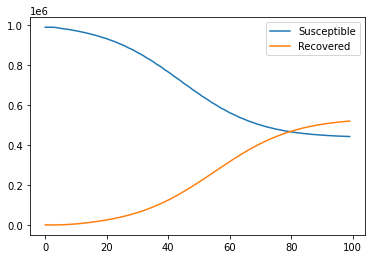

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

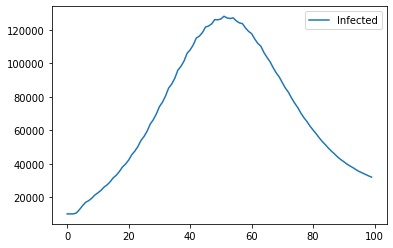

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

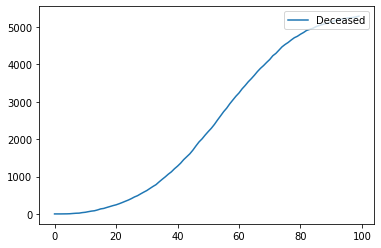

<IPython.core.display.Javascript object>

In [21]:
grid = widgets.Grid(1, 3, header_row=True, header_column=True)  # Grid object

with grid.output_to(0, 0):
  plt.plot(susceptible,label="Susceptible")
  plt.plot(recovered,label="Recovered")
  plt.legend(loc='upper right')
  plt.show()
with grid.output_to(0, 1):
  plt.plot(infected,label="Infected")
  plt.legend(loc='upper right')
  plt.show()
with grid.output_to(0, 2):
  plt.plot(deceased,label="Deceased")
  plt.legend(loc='upper right')
  plt.show()